# Sentiment Index Experiment Notebook
**Adam Watkins Master Thesis**

**Sep 29 2021**

This is the second experiment contained in the thesis. This experiment tests to see if the inclusion of a sentiment index aids a model with established technical and fundamental indicators in predicting daily changes in volatility as measured by the CBOE Volatility Index (VIX).

The two sentiment indices were calculated in the following ways:

$ i\_sentiment =\frac{N_{positive} - N_{negative}}{N}$

where $ N_{positive} $ and $ N_{negative} $ are the number of headlines whose highest sentiment probability score is positive and negative respectively. $ N $ is the total number of headlines. All indices are calculated per day.

and

$ p\_sentiment =\frac{ \sum P_{positive} - P_{negative}}{N}$

where $ P_{positive} $ and $ P_{negative} $ are the probability scores representing if a headline is positive and negative respectively. $ N $ is the total number of headlines. All indices are calculated per day.

All probabilties come from BERT as a zero-shot learner on all headlines for a single day.

All features are entered into artificial neural networks. Ideal hyperparameters were found using GridSearch.

In [ ]:
path = "add path to folder where data is contained here"

## Data Preparation

### Load Libraries and Data

In [ ]:
import numpy as np
import pandas as pd
import torch


#import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers import RMSprop


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.layers import Bidirectional

import random

from keras import backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import multilabel_confusion_matrix


import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(888)
random.seed(888)

In [ ]:
# headline, fundamentals and label
df = pd.read_csv(path+"exp2data.csv', header=0)

In [ ]:
# check correlation of sentiment indices
df.int_sent.corr(df.prob_sent)

-0.11436945753896324

### Create Benchmark DF

In [ ]:
X_small = df.loc[:,["open", "high", "low", "yc_spread", "yc_diff", "lead_ind", "oil_p", "eurusd_diff", "oilp_diff", "sp500_vol", "sp500_diff", "djia_vol", "djia_diff"]].copy()
X_small

,open,high,low,yc_spread,yc_diff,lead_ind,oil_p,eurusd_diff,oilp_diff,sp500_vol,sp500_diff,djia_vol,djia_diff
0,12.16,12.75,11.53,-3.248672,-0.109582,0.234344,-0.850531,0.050513,-0.371975,-0.507754,0.233892,1.551836,0.087296
1,11.84,12.25,11.68,-2.622507,1.174135,0.234344,-0.935477,0.005588,-1.018183,-0.934619,-0.520818,0.604579,-0.485298
2,12.48,12.83,11.78,-2.867528,0.639253,0.234344,-0.944308,-0.184765,-2.373934,-1.065302,-0.653750,0.483880,-0.543395
3,12.34,12.50,11.43,-1.578898,-1.393291,0.234344,-1.033879,-0.147000,-2.971838,-1.064197,-0.682353,0.515497,-0.661756
4,11.42,11.48,10.50,-2.059866,0.104375,0.234344,-1.119665,0.005732,-4.534761,-0.986144,-0.546895,0.877489,-0.609779
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,12.73,12.98,11.79,-0.598814,0.318325,0.486272,-1.539767,-0.231509,-0.198078,-0.273252,-0.812779,-1.153584,-0.880963
2041,11.40,11.92,11.02,-0.861984,0.853205,0.486272,-1.503602,-0.196371,-0.830332,-0.587188,-0.818674,-1.199000,-0.835107
2042,11.93,12.11,11.38,-0.598814,0.318325,0.486272,-1.472904,-0.187883,-0.130451,-0.512778,-0.698345,-1.081803,-0.442549
2043,11.61,12.00,11.28,-0.272119,0.746229,0.486272,-1.432534,-0.088477,-0.251750,-0.866573,-1.002907,-1.183655,-0.904503


In [ ]:
def buildLaggedFeatures(s,lag=2,dropna=True):
  if type(s) is pd.DataFrame:
    new_dict={}
    for col_name in s:
        new_dict[col_name]=s[col_name]
        # create lagged Series
        for l in range(1,lag+1):
            new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

  elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
  else:
        print ('Only works for DataFrame or Series')
        return None
  if dropna:
        return res.dropna()
  else:
        return res 

In [ ]:
X_small = buildLaggedFeatures(X_small,lag=5,dropna=True)
X_small

,open,open_lag1,open_lag2,open_lag3,open_lag4,open_lag5,high,high_lag1,high_lag2,high_lag3,high_lag4,high_lag5,low,low_lag1,low_lag2,low_lag3,low_lag4,low_lag5,yc_spread,yc_spread_lag1,yc_spread_lag2,yc_spread_lag3,yc_spread_lag4,yc_spread_lag5,yc_diff,yc_diff_lag1,yc_diff_lag2,yc_diff_lag3,yc_diff_lag4,yc_diff_lag5,lead_ind,lead_ind_lag1,lead_ind_lag2,lead_ind_lag3,lead_ind_lag4,lead_ind_lag5,oil_p,oil_p_lag1,oil_p_lag2,oil_p_lag3,oil_p_lag4,oil_p_lag5,eurusd_diff,eurusd_diff_lag1,eurusd_diff_lag2,eurusd_diff_lag3,eurusd_diff_lag4,eurusd_diff_lag5,oilp_diff,oilp_diff_lag1,oilp_diff_lag2,oilp_diff_lag3,oilp_diff_lag4,oilp_diff_lag5,sp500_vol,sp500_vol_lag1,sp500_vol_lag2,sp500_vol_lag3,sp500_vol_lag4,sp500_vol_lag5,sp500_diff,sp500_diff_lag1,sp500_diff_lag2,sp500_diff_lag3,sp500_diff_lag4,sp500_diff_lag5,djia_vol,djia_vol_lag1,djia_vol_lag2,djia_vol_lag3,djia_vol_lag4,djia_vol_lag5,djia_diff,djia_diff_lag1,djia_diff_lag2,djia_diff_lag3,djia_diff_lag4,djia_diff_lag5
5,10.64,11.42,12.34,12.48,11.84,12.16,10.89,11.48,12.50,12.83,12.25,12.75,10.40,10.50,11.43,11.78,11.68,11.53,-2.867528,-2.059866,-1.578898,-2.867528,-2.622507,-3.248672,-0.323534,0.104375,-1.393291,0.639253,1.174135,-0.109582,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.148261,-1.119665,-1.033879,-0.944308,-0.935477,-0.850531,-0.124307,0.005732,-0.147000,-0.184765,0.005588,0.050513,-4.540129,-4.534761,-2.971838,-2.373934,-1.018183,-0.371975,-1.202474,-0.986144,-1.064197,-1.065302,-0.934619,-0.507754,-1.133323,-0.546895,-0.682353,-0.653750,-0.520818,0.233892,0.681818,0.877489,0.515497,0.483880,0.604579,1.551836,-1.130961,-0.609779,-0.661756,-0.543395,-0.485298,0.087296
6,10.90,10.64,11.42,12.34,12.48,11.84,10.90,10.89,11.48,12.50,12.83,12.25,10.35,10.40,10.50,11.43,11.78,11.68,-2.849378,-2.867528,-2.059866,-1.578898,-2.867528,-2.622507,0.211349,-0.323534,0.104375,-1.393291,0.639253,1.174135,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.103265,-1.148261,-1.119665,-1.033879,-0.944308,-0.935477,-0.205177,-0.124307,0.005732,-0.147000,-0.184765,0.005588,0.115366,-4.540129,-4.534761,-2.971838,-2.373934,-1.018183,-1.126490,-1.202474,-0.986144,-1.064197,-1.065302,-0.934619,-1.016372,-1.133323,-0.546895,-0.682353,-0.653750,-0.520818,0.990773,0.681818,0.877489,0.515497,0.483880,0.604579,-0.968062,-1.130961,-0.609779,-0.661756,-0.543395,-0.485298
7,10.65,10.90,10.64,11.42,12.34,12.48,11.04,10.90,10.89,11.48,12.50,12.83,10.45,10.35,10.40,10.50,11.43,11.78,-2.840303,-2.849378,-2.867528,-2.059866,-1.578898,-2.867528,0.104375,0.211349,-0.323534,0.104375,-1.393291,0.639253,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.178538,-1.103265,-1.148261,-1.119665,-1.033879,-0.944308,-0.128493,-0.205177,-0.124307,0.005732,-0.147000,-0.184765,-0.191637,0.115366,-4.540129,-4.534761,-2.971838,-2.373934,-1.015821,-1.126490,-1.202474,-0.986144,-1.064197,-1.065302,-0.843899,-1.016372,-1.133323,-0.546895,-0.682353,-0.653750,0.763897,0.990773,0.681818,0.877489,0.515497,0.483880,-0.957516,-0.968062,-1.130961,-0.609779,-0.661756,-0.543395
8,10.80,10.65,10.90,10.64,11.42,12.34,11.03,11.04,10.90,10.89,11.48,12.50,10.24,10.45,10.35,10.40,10.50,11.43,-2.813079,-2.840303,-2.849378,-2.867528,-2.059866,-1.578898,0.318322,0.104375,0.211349,-0.323534,0.104375,-1.393291,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.116722,-1.178538,-1.103265,-1.148261,-1.119665,-1.033879,-0.098207,-0.128493,-0.205177,-0.124307,0.005732,-0.147000,0.158303,-0.191637,0.115366,-4.540129,-4.534761,-2.971838,-1.053461,-1.015821,-1.126490,-1.202474,-0.986144,-1.064197,-1.043301,-0.843899,-1.016372,-1.133323,-0.546895,-0.682353,1.142779,0.763897,0.990773,0.681818,0.877489,0.515497,-0.969569,-0.957516,-0.968062,-1.130961,-0.609779,-0.661756
9,10.77,10.80,10.65,10.90,10.64,11.42,11.08,11.03,11.04,10.90,10.89,11.48,10.62,10.24,10.45,10.35,10.40,10.50,-2.858453,-2.813079,-2.840303,-2.849378,-2.867528,-2.059866,-0.537481,0.318322,0.104375,0.211349,-0.323534,0.104375,0.234344,0.234344,0.234344,0.2

### Create DF with both indices

In [ ]:
X = df.loc[:,["open", "high", "low", "yc_spread", "yc_diff", "lead_ind", "oil_p", "eurusd_diff", "oilp_diff", "sp500_vol", "sp500_diff", "djia_vol", "djia_diff", "prob_sent", "int_sent"]].copy()
X

,open,high,low,yc_spread,yc_diff,lead_ind,oil_p,eurusd_diff,oilp_diff,sp500_vol,sp500_diff,djia_vol,djia_diff,prob_sent,int_sent
0,12.16,12.75,11.53,-3.248672,-0.109582,0.234344,-0.850531,0.050513,-0.371975,-0.507754,0.233892,1.551836,0.087296,-2.040547,1.000000
1,11.84,12.25,11.68,-2.622507,1.174135,0.234344,-0.935477,0.005588,-1.018183,-0.934619,-0.520818,0.604579,-0.485298,0.662489,0.000000
2,12.48,12.83,11.78,-2.867528,0.639253,0.234344,-0.944308,-0.184765,-2.373934,-1.065302,-0.653750,0.483880,-0.543395,-23.935843,0.666667
3,12.34,12.50,11.43,-1.578898,-1.393291,0.234344,-1.033879,-0.147000,-2.971838,-1.064197,-0.682353,0.515497,-0.661756,11.338476,0.100000
4,11.42,11.48,10.50,-2.059866,0.104375,0.234344,-1.119665,0.005732,-4.534761,-0.986144,-0.546895,0.877489,-0.609779,3.916210,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,12.73,12.98,11.79,-0.598814,0.318325,0.486272,-1.539767,-0.231509,-0.198078,-0.273252,-0.812779,-1.153584,-0.880963,-4.296086,0.750000
2041,11.40,11.92,11.02,-0.861984,0.853205,0.486272,-1.503602,-0.196371,-0.830332,-0.587188,-0.818674,-1.199000,-0.835107,-1.130907,-1.000000
2042,11.93,12.11,11.38,-0.598814,0.318325,0.486272,-1.472904,-0.187883,-0.130451,-0.512778,-0.698345,-1.081803,-0.442549,-3.882208,-1.000000
2043,11.61,12.00,11.28,-0.272119,0.746229,0.486272,-1.432534,-0.088477,-0.251750,-0.866573,-1.002907,-1.183655,-0.904503,-8.560446,0.500000


In [ ]:
X["prob_sent_diff"] = X['prob_sent'].diff().fillna(0)
X["int_sent_diff"] = X['int_sent'].diff().fillna(0)
X

,open,high,low,yc_spread,yc_diff,lead_ind,oil_p,eurusd_diff,oilp_diff,sp500_vol,sp500_diff,djia_vol,djia_diff,prob_sent,int_sent,prob_sent_diff,int_sent_diff
0,12.16,12.75,11.53,-3.248672,-0.109582,0.234344,-0.850531,0.050513,-0.371975,-0.507754,0.233892,1.551836,0.087296,-2.040547,1.000000,0.000000,0.000000
1,11.84,12.25,11.68,-2.622507,1.174135,0.234344,-0.935477,0.005588,-1.018183,-0.934619,-0.520818,0.604579,-0.485298,0.662489,0.000000,2.703036,-1.000000
2,12.48,12.83,11.78,-2.867528,0.639253,0.234344,-0.944308,-0.184765,-2.373934,-1.065302,-0.653750,0.483880,-0.543395,-23.935843,0.666667,-24.598331,0.666667
3,12.34,12.50,11.43,-1.578898,-1.393291,0.234344,-1.033879,-0.147000,-2.971838,-1.064197,-0.682353,0.515497,-0.661756,11.338476,0.100000,35.274319,-0.566667
4,11.42,11.48,10.50,-2.059866,0.104375,0.234344,-1.119665,0.005732,-4.534761,-0.986144,-0.546895,0.877489,-0.609779,3.916210,0.000000,-7.422266,-0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,12.73,12.98,11.79,-0.598814,0.318325,0.486272,-1.539767,-0.231509,-0.198078,-0.273252,-0.812779,-1.153584,-0.880963,-4.296086,0.750000,-5.614366,0.916667
2041,11.40,11.92,11.02,-0.861984,0.853205,0.486272,-1.503602,-0.196371,-0.830332,-0.587188,-0.818674,-1.199000,-0.835107,-1.130907,-1.000000,3.165179,-1.750000
2042,11.93,12.11,11.38,-0.598814,0.318325,0.486272,-1.472904,-0.187883,-0.130451,-0.512778,-0.698345,-1.081803,-0.442549,-3.882208,-1.000000,-2.751301,0.000000
2043,11.61,12.00,11.28,-0.272119,0.746229,0.486272,-1.432534,-0.088477,-0.251750,-0.866573,-1.002907,-1.183655,-0.904503,-8.560446,0.500000,-4.678238,1.500000


In [ ]:
X = buildLaggedFeatures(X,lag=5,dropna=True)
X

,open,open_lag1,open_lag2,open_lag3,open_lag4,open_lag5,high,high_lag1,high_lag2,high_lag3,high_lag4,high_lag5,low,low_lag1,low_lag2,low_lag3,low_lag4,low_lag5,yc_spread,yc_spread_lag1,yc_spread_lag2,yc_spread_lag3,yc_spread_lag4,yc_spread_lag5,yc_diff,yc_diff_lag1,yc_diff_lag2,yc_diff_lag3,yc_diff_lag4,yc_diff_lag5,lead_ind,lead_ind_lag1,lead_ind_lag2,lead_ind_lag3,lead_ind_lag4,lead_ind_lag5,oil_p,oil_p_lag1,oil_p_lag2,oil_p_lag3,...,sp500_diff_lag2,sp500_diff_lag3,sp500_diff_lag4,sp500_diff_lag5,djia_vol,djia_vol_lag1,djia_vol_lag2,djia_vol_lag3,djia_vol_lag4,djia_vol_lag5,djia_diff,djia_diff_lag1,djia_diff_lag2,djia_diff_lag3,djia_diff_lag4,djia_diff_lag5,prob_sent,prob_sent_lag1,prob_sent_lag2,prob_sent_lag3,prob_sent_lag4,prob_sent_lag5,int_sent,int_sent_lag1,int_sent_lag2,int_sent_lag3,int_sent_lag4,int_sent_lag5,prob_sent_diff,prob_sent_diff_lag1,prob_sent_diff_lag2,prob_sent_diff_lag3,prob_sent_diff_lag4,prob_sent_diff_lag5,int_sent_diff,int_sent_diff_lag1,int_sent_diff_lag2,int_sent_diff_lag3,int_sent_diff_lag4,int_sent_diff_lag5
5,10.64,11.42,12.34,12.48,11.84,12.16,10.89,11.48,12.50,12.83,12.25,12.75,10.40,10.50,11.43,11.78,11.68,11.53,-2.867528,-2.059866,-1.578898,-2.867528,-2.622507,-3.248672,-0.323534,0.104375,-1.393291,0.639253,1.174135,-0.109582,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.148261,-1.119665,-1.033879,-0.944308,...,-0.682353,-0.653750,-0.520818,0.233892,0.681818,0.877489,0.515497,0.483880,0.604579,1.551836,-1.130961,-0.609779,-0.661756,-0.543395,-0.485298,0.087296,-1.294198,3.916210,11.338476,-23.935843,0.662489,-2.040547,-0.500000,0.000000,0.100000,0.666667,0.000000,1.000000,-5.210408,-7.422266,35.274319,-24.598331,2.703036,0.000000,-0.500000,-0.100000,-0.566667,0.666667,-1.000000,0.000000
6,10.90,10.64,11.42,12.34,12.48,11.84,10.90,10.89,11.48,12.50,12.83,12.25,10.35,10.40,10.50,11.43,11.78,11.68,-2.849378,-2.867528,-2.059866,-1.578898,-2.867528,-2.622507,0.211349,-0.323534,0.104375,-1.393291,0.639253,1.174135,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.103265,-1.148261,-1.119665,-1.033879,...,-0.546895,-0.682353,-0.653750,-0.520818,0.990773,0.681818,0.877489,0.515497,0.483880,0.604579,-0.968062,-1.130961,-0.609779,-0.661756,-0.543395,-0.485298,-19.586210,-1.294198,3.916210,11.338476,-23.935843,0.662489,-0.200000,-0.500000,0.000000,0.100000,0.666667,0.000000,-18.292012,-5.210408,-7.422266,35.274319,-24.598331,2.703036,0.300000,-0.500000,-0.100000,-0.566667,0.666667,-1.000000
7,10.65,10.90,10.64,11.42,12.34,12.48,11.04,10.90,10.89,11.48,12.50,12.83,10.45,10.35,10.40,10.50,11.43,11.78,-2.840303,-2.849378,-2.867528,-2.059866,-1.578898,-2.867528,0.104375,0.211349,-0.323534,0.104375,-1.393291,0.639253,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.178538,-1.103265,-1.148261,-1.119665,...,-1.133323,-0.546895,-0.682353,-0.653750,0.763897,0.990773,0.681818,0.877489,0.515497,0.483880,-0.957516,-0.968062,-1.130961,-0.609779,-0.661756,-0.543395,-5.369672,-19.586210,-1.294198,3.916210,11.338476,-23.935843,-0.250000,-0.200000,-0.500000,0.000000,0.100000,0.666667,14.216538,-18.292012,-5.210408,-7.422266,35.274319,-24.598331,-0.050000,0.300000,-0.500000,-0.100000,-0.566667,0.666667
8,10.80,10.65,10.90,10.64,11.42,12.34,11.03,11.04,10.90,10.89,11.48,12.50,10.24,10.45,10.35,10.40,10.50,11.43,-2.813079,-2.840303,-2.849378,-2.867528,-2.059866,-1.578898,0.318322,0.104375,0.211349,-0.323534,0.104375,-1.393291,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.116722,-1.178538,-1.103265,-1.148261,...,-1.016372,-1.133323,-0.546895,-0.682353,1.142779,0.763897,0.990773,0.681818,0.877489,0.515497,-0.969569,-0.957516,-0.968062,-1.130961,-0.609779,-0.661756,-17.183825,-5.369672,-19.586210,-1.294198,3.916210,11.338476,0.500000,-0.250000,-0.200000,-0.500000,0.000000,0.100000,-11.814154,14.216538,-18.292012,-5.210408,-7.422266,35.274319,0.750000,-0.050000,0.300000,-0.500000,-0.100000,-0.566667
9,10.77,10.80,10.65,10.90,10.64,11.42,11.08,11.03,11.04,10.90,10.89,11.48,10.62,10.24,10.45

### Prepare Targets

In [ ]:
y_reg = df.loc[5:,["daily_diff"]]
y_reg

,daily_diff
5,0.10
6,-0.31
7,0.20
8,-0.40
9,0.00
...,...
2040,-0.31
2041,0.26
2042,-0.25
2043,-0.06


In [ ]:
y_class = df.loc[5:,["up", "stay", "down"]]
y_class

,up,stay,down
5,0,1,0
6,0,1,0
7,0,1,0
8,0,0,1
9,0,1,0
...,...,...,...
2040,0,1,0
2041,0,1,0
2042,0,1,0
2043,0,1,0


### Train-Test Split

In [ ]:
tscv = TimeSeriesSplit(max_train_size=None, n_splits=5)

for train_index, test_index in tscv.split(X_small):
  print('TRAIN:', train_index, 'TEST:', test_index)

X_small_train, X_small_test = X_small.iloc[train_index,:], X_small.iloc[test_index,:]
X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
y_class_train, y_class_test = y_class.iloc[train_index,:], y_class.iloc[test_index,:]
y_reg_train, y_reg_test = y_reg.iloc[train_index,:], y_reg.iloc[test_index,:]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

### Scaling

In [ ]:
standard_scaler_small = preprocessing.StandardScaler()
X_small_train = standard_scaler_small.fit_transform(X_small_train)
X_small_train = pd.DataFrame(X_small_train)
X_small_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77
0,-1.099876,-1.025973,-0.938826,-0.925509,-0.985843,-0.955402,-1.096737,-1.044016,-0.953078,-0.923500,-0.974980,-0.930279,-1.107499,-1.097155,-1.002120,-0.966385,-0.976478,-0.991567,-2.712924,-1.972812,-1.532593,-2.698260,-2.469688,-3.027443,-0.294604,0.093793,-1.266043,0.579976,1.064957,-0.100681,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.887395,-1.848640,-1.738987,-1.625043,-1.611708,-1.504030,-0.129441,-0.015295,-0.149385,-0.182567,-0.015528,0.023800,-4.239570,-4.210024,-2.758841,-2.203470,-0.955015,-0.359498,-1.190519,-0.987917,-1.060186,-1.060818,-0.938969,-0.542071,-1.099650,-0.503698,-0.641451,-0.611993,-0.476376,0.289900,0.483443,0.678412,0.318490,0.286387,0.405422,1.344729,-1.099858,-0.574985,-0.627220,-0.507851,-0.448945,0.127297
1,-1.075253,-1.099840,-1.025950,-0.938767,-0.925245,-0.985699,-1.095845,-1.096613,-1.044008,-0.952917,-0.923284,-0.974841,-1.112605,-1.107366,-1.097086,-1.002125,-0.966267,-0.976252,-2.696371,-2.708593,-1.970457,-1.527621,-2.691877,-2.461156,0.191445,-0.295101,0.094435,-1.266207,0.579274,1.064957,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.831246,-1.884289,-1.845841,-1.736529,-1.622692,-1.609615,-0.200448,-0.129474,-0.015281,-0.149408,-0.182667,-0.015646,0.082666,-4.214981,-4.199072,-2.753650,-2.202230,-0.955385,-1.119747,-1.189371,-0.987514,-1.059789,-1.060608,-0.939492,-0.980805,-1.099620,-0.503793,-0.641057,-0.611451,-0.477103,0.789818,0.484259,0.677795,0.317779,0.285530,0.403860,-0.935786,-1.099936,-0.574869,-0.627056,-0.507454,-0.449406
2,-1.098929,-1.075217,-1.099816,-1.025888,-0.938501,-0.925105,-1.083364,-1.095722,-1.096605,-1.043840,-0.952698,-0.923149,-1.102392,-1.112472,-1.107298,-1.097092,-1.002005,-0.966043,-2.688094,-2.692058,-2.705736,-1.964550,-1.523329,-2.682747,0.094238,0.191013,-0.294277,0.094140,-1.266312,0.579274,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.925178,-1.828194,-1.881459,-1.843305,-1.734098,-1.620592,-0.133117,-0.200481,-0.129460,-0.015303,-0.149508,-0.182786,-0.202360,0.084661,-4.204018,-4.191824,-2.752268,-2.205560,-1.016669,-1.118612,-1.188930,-0.987131,-1.059579,-1.061160,-0.805537,-0.980776,-1.099745,-0.503414,-0.640515,-0.612200,0.564837,0.790816,0.483576,0.677204,0.316935,0.283976,-0.925164,-0.935859,-1.099795,-0.574708,-0.626652,-0.507921
3,-1.084724,-1.098893,-1.075194,-1.099752,-1.025611,-0.938360,-1.084256,-1.083241,-1.095713,-1.096433,-1.043611,-0.952560,-1.123839,-1.102261,-1.112403,-1.107304,-1.096967,-1.001777,-2.663264,-2.683791,-2.689213,-2.698260,-1.959477,-1.517345,0.288652,0.093793,0.191610,-0.294534,0.093596,-1.266312,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.848038,-1.922034,-1.825413,-1.878896,-1.840797,-1.731927,-0.106524,-0.133150,-0.200467,-0.129483,-0.015402,-0.149627,0.122530,-0.198876,0.086009,-4.196762,-4.190070,-2.756904,-1.051728,-1.015553,-1.118184,-1.188509,-0.986928,-1.060131,-1.008170,-0.805510,-0.980894,-1.099301,-0.502874,-0.641270,0.940554,0.565701,0.790238,0.482920,0.676508,0.315379,-0.937303,-0.925237,-0.935726,-1.099607,-0.574307,-0.627131
4,-1.087565,-1.084687,-1.098869,-1.075130,-1.099465,-1.025464,-1.079798,-1.084133,-1.083233,-1.095541,-1.096199,-1.043468,-1.085031,-1.123705,-1.102192,-1.112410,-1.107178,-1.096728,-2.704647,-2.658989,-2.680951,-2.681772,-2.691877,-1.952319,-0.489018,0.288234,0.094435,0.191306,-0.294953,0.093596,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.893693,-1.844970,-1.919172,-1.822892,-1.876363,-1.838558,-0.194845,-0.106557,-0.133136,-0.200490,-0.129582,-0.015519,-0.110673,0.124316,-0.196893,0.087138,-4.195007,-4.198119,-1.236855,-1.050605,-1.015145,-1.117776,-1.188288,-0.987462,-0.614020,-1.008141,-0.805620,-0.980464,-1.098753,-0.503605,1.001012,0.941642,0.565046,0.789684,0.482144,0.674930,-0.383441,-0.

In [ ]:
X_small_test = standard_scaler_small.transform(X_small_test)
X_small_test = pd.DataFrame(X_small_test)
X_small_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77
0,-0.704020,-0.996616,-0.918939,-0.870585,-0.735875,-0.824746,-0.735669,-0.943280,-0.945946,-0.771962,-0.771762,-0.801938,-0.757211,-0.992994,-0.945956,-0.971491,-0.870284,-0.786350,0.092859,0.127057,0.185812,0.195362,0.188347,0.173309,-0.391811,-0.683989,-0.099921,0.094138,0.190730,-0.100679,1.007457,1.008080,1.008703,1.009327,1.009952,1.010577,0.228445,0.275604,0.310094,0.376993,0.408247,0.301895,-0.184071,-0.072182,-0.124998,-0.220390,-0.182718,-0.176246,-0.015000,-0.084866,-0.144467,-0.075842,0.184561,2.866409,-0.660297,0.589111,-0.693219,-0.713094,-0.751195,-1.050877,-0.472944,-0.470352,-0.761157,-0.061420,0.432408,-0.809715,-1.208049,1.576623,-1.125580,-1.101105,-1.251989,-1.268385,-0.437310,-0.653893,-0.478704,-0.284520,0.184316,-0.584549
1,-0.722960,-0.703990,-0.996593,-0.918880,-0.870328,-0.735748,-0.736560,-0.735566,-0.943272,-0.945785,-0.771762,-0.771636,-0.817465,-0.757101,-0.992929,-0.945962,-0.971372,-0.870070,0.117689,0.093988,0.127981,0.187118,0.196576,0.189723,0.288655,-0.392322,-0.682983,-0.100197,0.093594,0.190730,1.007457,1.008080,1.008703,1.009327,1.009952,1.010577,0.336022,0.229470,0.276571,0.311044,0.377911,0.409049,-0.095369,-0.184105,-0.072167,-0.125021,-0.220491,-0.182837,0.180333,-0.012495,-0.083139,-0.143009,-0.075152,0.186897,-0.633389,-0.659247,0.589215,-0.692889,-0.712917,-0.751673,0.255512,-0.472920,-0.470446,-0.760750,-0.060885,0.431834,-1.172919,-1.208240,1.576314,-1.126770,-1.102533,-1.253451,0.289729,-0.437369,-0.653774,-0.478548,-0.284134,0.183915
2,-0.771259,-0.722931,-0.703971,-0.996532,-0.918617,-0.870191,-0.579652,-0.736458,-0.735559,-0.943111,-0.945567,-0.771636,-0.736786,-0.817351,-0.757044,-0.992935,-0.945845,-0.971147,0.076306,0.118790,0.094935,0.129410,0.188347,0.197930,-0.489021,0.288236,-0.391452,-0.683203,-0.100679,0.093594,1.007457,1.008080,1.008703,1.009327,1.009952,1.010577,0.335497,0.336940,0.230478,0.277546,0.312009,0.378732,-0.117830,-0.095403,-0.184090,-0.072190,-0.125120,-0.220610,-0.024966,0.181817,-0.010929,-0.081768,-0.142302,-0.073433,-0.665211,-0.632344,-0.658907,0.589313,-0.692714,-0.713386,1.125034,0.255529,-0.473013,-0.470071,-0.760207,-0.061542,-1.040258,-1.173089,-1.209504,1.576021,-1.128210,-1.104004,0.919368,0.289691,-0.437260,-0.653609,-0.478152,-0.284580
3,-0.614053,-0.771228,-0.722911,-0.703918,-0.996259,-0.918477,-0.642950,-0.579558,-0.736451,-0.735414,-0.942893,-0.945430,-0.708191,-0.736678,-0.817292,-0.757049,-0.992815,-0.945623,0.068029,0.077454,0.119720,0.096435,0.130743,0.189723,-0.100183,-0.489544,0.288787,-0.391700,-0.683496,-0.100679,1.007457,1.008080,1.008703,1.009327,1.009952,1.010577,0.438350,0.336416,0.337855,0.231486,0.278535,0.312872,-0.119275,-0.117864,-0.095389,-0.184113,-0.072289,-0.125239,0.171363,-0.022409,0.182948,-0.009662,-0.081077,-0.140742,-0.933208,-0.664160,-0.632009,-0.658582,0.589368,-0.693178,0.169157,1.125042,0.255472,-0.472638,-0.469530,-0.760981,-1.232764,-1.040350,-1.174340,-1.210721,1.575696,-1.129679,0.359626,0.919348,0.289764,-0.437106,-0.653204,-0.478616
4,-0.640569,-0.614025,-0.771208,-0.722858,-0.703682,-0.996114,-0.602831,-0.642853,-0.579552,-0.736306,-0.735218,-0.942756,-0.619343,-0.708085,-0.736621,-0.817297,-0.756943,-0.992588,0.051476,0.069187,0.078412,0.121166,0.097826,0.132274,0.191445,-0.100654,-0.488629,0.288473,-0.392087,-0.683496,1.007457,1.008080,1.008703,1.009327,1.009952,1.010577,0.208504,0.439168,0.337331,0.338784,0.232508,0.279419,0.005247,-0.119309,-0.117849,-0.095411,-0.184213,-0.072407,-0.358826,0.172894,-0.020821,0.183938,-0.008989,-0.079372,-0.136370,-0.932107,-0.663818,-0.631689,-0.658410,0.589209,-0.167705,0.169175,1.125028,0.255768,-0.472098,-0.470256,-0.950695,-1.232969,-1.041555,-1.175546,-1.212195,1.574064,-0.323692,0.359590,0.919391,0.289881,-0.436712,-0.653685
...,...

In [ ]:
standard_scaler = preprocessing.StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
0,-1.099876,-1.025973,-0.938826,-0.925509,-0.985843,-0.955402,-1.096737,-1.044016,-0.953078,-0.923500,-0.974980,-0.930279,-1.107499,-1.097155,-1.002120,-0.966385,-0.976478,-0.991567,-2.712924,-1.972812,-1.532593,-2.698260,-2.469688,-3.027443,-0.294604,0.093793,-1.266043,0.579976,1.064957,-0.100681,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.887395,-1.848640,-1.738987,-1.625043,...,-0.641451,-0.611993,-0.476376,0.289900,0.483443,0.678412,0.318490,0.286387,0.405422,1.344729,-1.099858,-0.574985,-0.627220,-0.507851,-0.448945,0.127297,-0.145480,0.104648,0.461435,-1.231280,-0.050007,-0.179826,-3.102320,-0.584744,-0.080229,2.770239,-0.583650,4.448926,-0.175309,-0.250027,1.186181,-0.827711,0.090962,-0.000159,-1.866725,-0.373970,-2.114310,2.483296,-3.718454,0.001902
1,-1.075253,-1.099840,-1.025950,-0.938767,-0.925245,-0.985699,-1.095845,-1.096613,-1.044008,-0.952917,-0.923284,-0.974841,-1.112605,-1.107366,-1.097086,-1.002125,-0.966267,-0.976252,-2.696371,-2.708593,-1.970457,-1.527621,-2.691877,-2.461156,0.191445,-0.295101,0.094435,-1.266207,0.579274,1.064957,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.831246,-1.884289,-1.845841,-1.736529,...,-0.503793,-0.641057,-0.611451,-0.477103,0.789818,0.484259,0.677795,0.317779,0.285530,0.403860,-0.935786,-1.099936,-0.574869,-0.627056,-0.507454,-0.449406,-1.023842,-0.145549,0.104955,0.462217,-1.231045,-0.050045,-1.591014,-3.105854,-0.584477,-0.081229,2.771401,-0.583650,-0.615573,-0.175578,-0.250410,1.186392,-0.827521,0.090781,1.120914,-1.868970,-0.372401,-2.111960,2.478969,-3.727970
2,-1.098929,-1.075217,-1.099816,-1.025888,-0.938501,-0.925105,-1.083364,-1.095722,-1.096605,-1.043840,-0.952698,-0.923149,-1.102392,-1.112472,-1.107298,-1.097092,-1.002005,-0.966043,-2.688094,-2.692058,-2.705736,-1.964550,-1.523329,-2.682747,0.094238,0.191013,-0.294277,0.094140,-1.266312,0.579274,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.925178,-1.828194,-1.881459,-1.843305,...,-1.099745,-0.503414,-0.640515,-0.612200,0.564837,0.790816,0.483576,0.677204,0.316935,0.283976,-0.925164,-0.935859,-1.099795,-0.574708,-0.626652,-0.507921,-0.341180,-1.023908,-0.145292,0.105879,0.462578,-1.231091,-1.842898,-1.593188,-3.105716,-0.584429,-0.080392,2.771401,0.478509,-0.615892,-0.175989,-0.249912,1.186739,-0.827729,-0.186178,1.121030,-1.865466,-0.373215,-2.107124,2.488482
3,-1.084724,-1.098893,-1.075194,-1.099752,-1.025611,-0.938360,-1.084256,-1.083241,-1.095713,-1.096433,-1.043611,-0.952560,-1.123839,-1.102261,-1.112403,-1.107304,-1.096967,-1.001777,-2.663264,-2.683791,-2.689213,-2.698260,-1.959477,-1.517345,0.288652,0.093793,0.191610,-0.294534,0.093596,-1.266312,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.848038,-1.922034,-1.825413,-1.878896,...,-0.980894,-1.099301,-0.502874,-0.641270,0.940554,0.565701,0.790238,0.482920,0.676508,0.315379,-0.937303,-0.925237,-0.935726,-1.099607,-0.574307,-0.627131,-0.908483,-0.341248,-1.023829,-0.144269,0.106213,0.462544,1.935366,-1.845299,-1.592972,-3.100430,-0.583650,-0.080392,-0.397559,0.478315,-0.616139,-0.175505,-0.249677,1.186589,2.801461,-0.187095,1.120663,-1.863568,-0.371845,-2.111692
4,-1.087565,-1.084687,-1.098869,-1.075130,-1.099465,-1.025464,-1.079798,-1.084133,-1.083233,-1.095541,-1.096199,-1.043468,-1.085031,-1.123705,-1.102192,-1.112410,-1.107178,-1.096728,-2.704647,-2.658989,-2.680951,-2.681772,-2.691877,-1.952319,-0.489018,0.288234,0.094435,0.191306,-0.294953,0.093596,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.893693,-1.844970,-1.919172,-1.822892,...,-0.805620,-0.980464,-1.098753,-0.503605,1.001012,0.941642,0.565046,0.789684,0.482144,0.674930,-0.383441,-0.937376,-0.925105,-0.935546,-1.099180,-0.574781,-0.145564,-0.908549,-0.341031,-1.022457,-0.143954,0.106177,-2.682513,1.936366,-1.84

In [ ]:
X_test = standard_scaler.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
0,-0.704020,-0.996616,-0.918939,-0.870585,-0.735875,-0.824746,-0.735669,-0.943280,-0.945946,-0.771962,-0.771762,-0.801938,-0.757211,-0.992994,-0.945956,-0.971491,-0.870284,-0.786350,0.092859,0.127057,0.185812,0.195362,0.188347,0.173309,-0.391811,-0.683989,-0.099921,0.094138,0.190730,-0.100679,1.007457,1.008080,1.008703,1.009327,1.009952,1.010577,0.228445,0.275604,0.310094,0.376993,...,-0.761157,-0.061420,0.432408,-0.809715,-1.208049,1.576623,-1.125580,-1.101105,-1.251989,-1.268385,-0.437310,-0.653893,-0.478704,-0.284520,0.184316,-0.584549,0.860892,-0.012959,0.947341,0.410459,0.504244,-0.242224,-0.125506,-1.845299,0.424018,0.787935,0.854229,4.448926,0.612460,-0.672995,0.376001,-0.065688,0.523045,-0.313403,1.273691,-1.682095,-0.270601,-0.049014,-2.656039e+00,3.234457
1,-0.722960,-0.703990,-0.996593,-0.918880,-0.870328,-0.735748,-0.736560,-0.735566,-0.943272,-0.945785,-0.771762,-0.771636,-0.817465,-0.757101,-0.992929,-0.945962,-0.971372,-0.870070,0.117689,0.093988,0.127981,0.187118,0.196576,0.189723,0.288655,-0.392322,-0.682983,-0.100197,0.093594,0.190730,1.007457,1.008080,1.008703,1.009327,1.009952,1.010577,0.336022,0.229470,0.276571,0.311044,...,-0.470446,-0.760750,-0.060885,0.431834,-1.172919,-1.208240,1.576314,-1.126770,-1.102533,-1.253451,0.289729,-0.437369,-0.653774,-0.478548,-0.284134,0.183915,0.302242,0.860820,-0.012676,0.947931,0.410815,0.504211,0.790437,-0.126360,-1.845096,0.421972,0.788871,0.854229,-0.391495,0.612281,-0.673221,0.376374,-0.065439,0.522876,0.679558,1.273928,-1.678833,-0.271600,-4.829161e-02,-2.662292
2,-0.771259,-0.722931,-0.703971,-0.996532,-0.918617,-0.870191,-0.579652,-0.736458,-0.735559,-0.943111,-0.945567,-0.771636,-0.736786,-0.817351,-0.757044,-0.992935,-0.945845,-0.971147,0.076306,0.118790,0.094935,0.129410,0.188347,0.197930,-0.489021,0.288236,-0.391452,-0.683203,-0.100679,0.093594,1.007457,1.008080,1.008703,1.009327,1.009952,1.010577,0.335497,0.336940,0.230478,0.277546,...,-0.473013,-0.470071,-0.760207,-0.061542,-1.040258,-1.173089,-1.209504,1.576021,-1.128210,-1.104004,0.919368,0.289691,-0.437260,-0.653609,-0.478152,-0.284580,0.244687,0.302172,0.861279,-0.011705,0.948327,0.410782,0.790437,0.790407,-0.126070,-1.842429,0.422865,0.788871,-0.040291,-0.391788,0.611577,-0.672638,0.376658,-0.065625,0.000549,0.679326,1.273363,-1.677274,-2.704330e-01,-0.046538
3,-0.614053,-0.771228,-0.722911,-0.703918,-0.996259,-0.918477,-0.642950,-0.579558,-0.736451,-0.735414,-0.942893,-0.945430,-0.708191,-0.736678,-0.817292,-0.757049,-0.992815,-0.945623,0.068029,0.077454,0.119720,0.096435,0.130743,0.189723,-0.100183,-0.489544,0.288787,-0.391700,-0.683496,-0.100679,1.007457,1.008080,1.008703,1.009327,1.009952,1.010577,0.438350,0.336416,0.337855,0.231486,...,0.255472,-0.472638,-0.469530,-0.760981,-1.232764,-1.040350,-1.174340,-1.210721,1.575696,-1.129679,0.359626,0.919348,0.289764,-0.437106,-0.653204,-0.478616,-1.559523,0.244617,0.302519,0.861903,-0.011380,0.948297,-0.195963,0.790407,0.790744,-0.126974,-1.841794,0.422865,-1.264476,-0.040544,-0.392119,0.611902,-0.672436,0.376484,-0.730691,-0.000220,0.679531,1.269561,-1.673304e+00,-0.269362
4,-0.640569,-0.614025,-0.771208,-0.722858,-0.703682,-0.996114,-0.602831,-0.642853,-0.579552,-0.736306,-0.735218,-0.942756,-0.619343,-0.708085,-0.736621,-0.817297,-0.756943,-0.992588,0.051476,0.069187,0.078412,0.121166,0.097826,0.132274,0.191445,-0.100654,-0.488629,0.288473,-0.392087,-0.683496,1.007457,1.008080,1.008703,1.009327,1.009952,1.010577,0.208504,0.439168,0.337331,0.338784,...,1.125028,0.255768,-0.472098,-0.470256,-0.950695,-1.232969,-1.041555,-1.175546,-1.212195,1.574064,-0.323692,0.359590,0.919391,0.289881,-0.436712,-0.653685,1.027948,-1.559588,0.244952,0.303364,0.862293,-0.011417,0.376082,-0.196881,0.790744,0.787935,-0.126143,-1.841794,1.81354

In [ ]:
standard_scaler_y = preprocessing.StandardScaler()
y_reg_train_scaled = standard_scaler_y.fit_transform(y_reg_train)
y_reg_train_scaled = pd.DataFrame(y_reg_train_scaled)

y_reg_test_scaled = standard_scaler_y.transform(y_reg_test)
y_reg_test_scaled = pd.DataFrame(y_reg_test_scaled)
y_reg_test_scaled

,0
0,0.144640
1,-0.722835
2,0.988348
3,-0.467346
4,0.566494
...,...
335,-0.104908
336,0.233764
337,-0.069258
338,0.043632


### Fully Prepare DF with p_sentiment

In [ ]:
X_p = df.loc[:,["open", "high", "low", "yc_spread", "yc_diff", "lead_ind", "oil_p", "eurusd_diff", "oilp_diff", "sp500_vol", "sp500_diff", "djia_vol", "djia_diff", "prob_sent"]].copy()
X_p

,open,high,low,yc_spread,yc_diff,lead_ind,oil_p,eurusd_diff,oilp_diff,sp500_vol,sp500_diff,djia_vol,djia_diff,prob_sent
0,12.16,12.75,11.53,-3.248672,-0.109582,0.234344,-0.850531,0.050513,-0.371975,-0.507754,0.233892,1.551836,0.087296,-2.040547
1,11.84,12.25,11.68,-2.622507,1.174135,0.234344,-0.935477,0.005588,-1.018183,-0.934619,-0.520818,0.604579,-0.485298,0.662489
2,12.48,12.83,11.78,-2.867528,0.639253,0.234344,-0.944308,-0.184765,-2.373934,-1.065302,-0.653750,0.483880,-0.543395,-23.935843
3,12.34,12.50,11.43,-1.578898,-1.393291,0.234344,-1.033879,-0.147000,-2.971838,-1.064197,-0.682353,0.515497,-0.661756,11.338476
4,11.42,11.48,10.50,-2.059866,0.104375,0.234344,-1.119665,0.005732,-4.534761,-0.986144,-0.546895,0.877489,-0.609779,3.916210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,12.73,12.98,11.79,-0.598814,0.318325,0.486272,-1.539767,-0.231509,-0.198078,-0.273252,-0.812779,-1.153584,-0.880963,-4.296086
2041,11.40,11.92,11.02,-0.861984,0.853205,0.486272,-1.503602,-0.196371,-0.830332,-0.587188,-0.818674,-1.199000,-0.835107,-1.130907
2042,11.93,12.11,11.38,-0.598814,0.318325,0.486272,-1.472904,-0.187883,-0.130451,-0.512778,-0.698345,-1.081803,-0.442549,-3.882208
2043,11.61,12.00,11.28,-0.272119,0.746229,0.486272,-1.432534,-0.088477,-0.251750,-0.866573,-1.002907,-1.183655,-0.904503,-8.560446


In [ ]:
X_p["prob_sent_diff"] = X_p['prob_sent'].diff().fillna(0)
X_p

,open,high,low,yc_spread,yc_diff,lead_ind,oil_p,eurusd_diff,oilp_diff,sp500_vol,sp500_diff,djia_vol,djia_diff,prob_sent,prob_sent_diff
0,12.16,12.75,11.53,-3.248672,-0.109582,0.234344,-0.850531,0.050513,-0.371975,-0.507754,0.233892,1.551836,0.087296,-2.040547,0.000000
1,11.84,12.25,11.68,-2.622507,1.174135,0.234344,-0.935477,0.005588,-1.018183,-0.934619,-0.520818,0.604579,-0.485298,0.662489,2.703036
2,12.48,12.83,11.78,-2.867528,0.639253,0.234344,-0.944308,-0.184765,-2.373934,-1.065302,-0.653750,0.483880,-0.543395,-23.935843,-24.598331
3,12.34,12.50,11.43,-1.578898,-1.393291,0.234344,-1.033879,-0.147000,-2.971838,-1.064197,-0.682353,0.515497,-0.661756,11.338476,35.274319
4,11.42,11.48,10.50,-2.059866,0.104375,0.234344,-1.119665,0.005732,-4.534761,-0.986144,-0.546895,0.877489,-0.609779,3.916210,-7.422266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,12.73,12.98,11.79,-0.598814,0.318325,0.486272,-1.539767,-0.231509,-0.198078,-0.273252,-0.812779,-1.153584,-0.880963,-4.296086,-5.614366
2041,11.40,11.92,11.02,-0.861984,0.853205,0.486272,-1.503602,-0.196371,-0.830332,-0.587188,-0.818674,-1.199000,-0.835107,-1.130907,3.165179
2042,11.93,12.11,11.38,-0.598814,0.318325,0.486272,-1.472904,-0.187883,-0.130451,-0.512778,-0.698345,-1.081803,-0.442549,-3.882208,-2.751301
2043,11.61,12.00,11.28,-0.272119,0.746229,0.486272,-1.432534,-0.088477,-0.251750,-0.866573,-1.002907,-1.183655,-0.904503,-8.560446,-4.678238


In [ ]:
X_p = buildLaggedFeatures(X_p,lag=5,dropna=True)
X_p

,open,open_lag1,open_lag2,open_lag3,open_lag4,open_lag5,high,high_lag1,high_lag2,high_lag3,high_lag4,high_lag5,low,low_lag1,low_lag2,low_lag3,low_lag4,low_lag5,yc_spread,yc_spread_lag1,yc_spread_lag2,yc_spread_lag3,yc_spread_lag4,yc_spread_lag5,yc_diff,yc_diff_lag1,yc_diff_lag2,yc_diff_lag3,yc_diff_lag4,yc_diff_lag5,lead_ind,lead_ind_lag1,lead_ind_lag2,lead_ind_lag3,lead_ind_lag4,lead_ind_lag5,oil_p,oil_p_lag1,oil_p_lag2,oil_p_lag3,...,oilp_diff_lag2,oilp_diff_lag3,oilp_diff_lag4,oilp_diff_lag5,sp500_vol,sp500_vol_lag1,sp500_vol_lag2,sp500_vol_lag3,sp500_vol_lag4,sp500_vol_lag5,sp500_diff,sp500_diff_lag1,sp500_diff_lag2,sp500_diff_lag3,sp500_diff_lag4,sp500_diff_lag5,djia_vol,djia_vol_lag1,djia_vol_lag2,djia_vol_lag3,djia_vol_lag4,djia_vol_lag5,djia_diff,djia_diff_lag1,djia_diff_lag2,djia_diff_lag3,djia_diff_lag4,djia_diff_lag5,prob_sent,prob_sent_lag1,prob_sent_lag2,prob_sent_lag3,prob_sent_lag4,prob_sent_lag5,prob_sent_diff,prob_sent_diff_lag1,prob_sent_diff_lag2,prob_sent_diff_lag3,prob_sent_diff_lag4,prob_sent_diff_lag5
5,10.64,11.42,12.34,12.48,11.84,12.16,10.89,11.48,12.50,12.83,12.25,12.75,10.40,10.50,11.43,11.78,11.68,11.53,-2.867528,-2.059866,-1.578898,-2.867528,-2.622507,-3.248672,-0.323534,0.104375,-1.393291,0.639253,1.174135,-0.109582,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.148261,-1.119665,-1.033879,-0.944308,...,-2.971838,-2.373934,-1.018183,-0.371975,-1.202474,-0.986144,-1.064197,-1.065302,-0.934619,-0.507754,-1.133323,-0.546895,-0.682353,-0.653750,-0.520818,0.233892,0.681818,0.877489,0.515497,0.483880,0.604579,1.551836,-1.130961,-0.609779,-0.661756,-0.543395,-0.485298,0.087296,-1.294198,3.916210,11.338476,-23.935843,0.662489,-2.040547,-5.210408,-7.422266,35.274319,-24.598331,2.703036,0.000000
6,10.90,10.64,11.42,12.34,12.48,11.84,10.90,10.89,11.48,12.50,12.83,12.25,10.35,10.40,10.50,11.43,11.78,11.68,-2.849378,-2.867528,-2.059866,-1.578898,-2.867528,-2.622507,0.211349,-0.323534,0.104375,-1.393291,0.639253,1.174135,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.103265,-1.148261,-1.119665,-1.033879,...,-4.534761,-2.971838,-2.373934,-1.018183,-1.126490,-1.202474,-0.986144,-1.064197,-1.065302,-0.934619,-1.016372,-1.133323,-0.546895,-0.682353,-0.653750,-0.520818,0.990773,0.681818,0.877489,0.515497,0.483880,0.604579,-0.968062,-1.130961,-0.609779,-0.661756,-0.543395,-0.485298,-19.586210,-1.294198,3.916210,11.338476,-23.935843,0.662489,-18.292012,-5.210408,-7.422266,35.274319,-24.598331,2.703036
7,10.65,10.90,10.64,11.42,12.34,12.48,11.04,10.90,10.89,11.48,12.50,12.83,10.45,10.35,10.40,10.50,11.43,11.78,-2.840303,-2.849378,-2.867528,-2.059866,-1.578898,-2.867528,0.104375,0.211349,-0.323534,0.104375,-1.393291,0.639253,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.178538,-1.103265,-1.148261,-1.119665,...,-4.540129,-4.534761,-2.971838,-2.373934,-1.015821,-1.126490,-1.202474,-0.986144,-1.064197,-1.065302,-0.843899,-1.016372,-1.133323,-0.546895,-0.682353,-0.653750,0.763897,0.990773,0.681818,0.877489,0.515497,0.483880,-0.957516,-0.968062,-1.130961,-0.609779,-0.661756,-0.543395,-5.369672,-19.586210,-1.294198,3.916210,11.338476,-23.935843,14.216538,-18.292012,-5.210408,-7.422266,35.274319,-24.598331
8,10.80,10.65,10.90,10.64,11.42,12.34,11.03,11.04,10.90,10.89,11.48,12.50,10.24,10.45,10.35,10.40,10.50,11.43,-2.813079,-2.840303,-2.849378,-2.867528,-2.059866,-1.578898,0.318322,0.104375,0.211349,-0.323534,0.104375,-1.393291,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.116722,-1.178538,-1.103265,-1.148261,...,0.115366,-4.540129,-4.534761,-2.971838,-1.053461,-1.015821,-1.126490,-1.202474,-0.986144,-1.064197,-1.043301,-0.843899,-1.016372,-1.133323,-0.546895,-0.682353,1.142779,0.763897,0.990773,0.681818,0.877489,0.515497,-0.969569,-0.957516,-0.968062,-1.130961,-0.609779,-0.661756,-17.183825,-5.369672,-19.586210,-1.294198,3.916210,11.338476,-11.814154,14.216538,-18.292012,-5.210408,-7.422266,35.274319
9,10.77,10.80,10.65,10.90,10.64,11.42,11.08,11.03,11.04,10.90,10.89,11.48,10.62,10.24

In [ ]:
X_p_train, X_p_test = X_p.iloc[train_index,:], X_p.iloc[test_index,:]

In [ ]:
standard_scaler_p = preprocessing.StandardScaler()
X_p_train = standard_scaler_p.fit_transform(X_p_train)
X_p_train = pd.DataFrame(X_p_train)
X_p_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,-1.099876,-1.025973,-0.938826,-0.925509,-0.985843,-0.955402,-1.096737,-1.044016,-0.953078,-0.923500,-0.974980,-0.930279,-1.107499,-1.097155,-1.002120,-0.966385,-0.976478,-0.991567,-2.712924,-1.972812,-1.532593,-2.698260,-2.469688,-3.027443,-0.294604,0.093793,-1.266043,0.579976,1.064957,-0.100681,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.887395,-1.848640,-1.738987,-1.625043,...,-2.758841,-2.203470,-0.955015,-0.359498,-1.190519,-0.987917,-1.060186,-1.060818,-0.938969,-0.542071,-1.099650,-0.503698,-0.641451,-0.611993,-0.476376,0.289900,0.483443,0.678412,0.318490,0.286387,0.405422,1.344729,-1.099858,-0.574985,-0.627220,-0.507851,-0.448945,0.127297,-0.145480,0.104648,0.461435,-1.231280,-0.050007,-0.179826,-0.175309,-0.250027,1.186181,-0.827711,0.090962,-0.000159
1,-1.075253,-1.099840,-1.025950,-0.938767,-0.925245,-0.985699,-1.095845,-1.096613,-1.044008,-0.952917,-0.923284,-0.974841,-1.112605,-1.107366,-1.097086,-1.002125,-0.966267,-0.976252,-2.696371,-2.708593,-1.970457,-1.527621,-2.691877,-2.461156,0.191445,-0.295101,0.094435,-1.266207,0.579274,1.064957,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.831246,-1.884289,-1.845841,-1.736529,...,-4.199072,-2.753650,-2.202230,-0.955385,-1.119747,-1.189371,-0.987514,-1.059789,-1.060608,-0.939492,-0.980805,-1.099620,-0.503793,-0.641057,-0.611451,-0.477103,0.789818,0.484259,0.677795,0.317779,0.285530,0.403860,-0.935786,-1.099936,-0.574869,-0.627056,-0.507454,-0.449406,-1.023842,-0.145549,0.104955,0.462217,-1.231045,-0.050045,-0.615573,-0.175578,-0.250410,1.186392,-0.827521,0.090781
2,-1.098929,-1.075217,-1.099816,-1.025888,-0.938501,-0.925105,-1.083364,-1.095722,-1.096605,-1.043840,-0.952698,-0.923149,-1.102392,-1.112472,-1.107298,-1.097092,-1.002005,-0.966043,-2.688094,-2.692058,-2.705736,-1.964550,-1.523329,-2.682747,0.094238,0.191013,-0.294277,0.094140,-1.266312,0.579274,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.925178,-1.828194,-1.881459,-1.843305,...,-4.204018,-4.191824,-2.752268,-2.205560,-1.016669,-1.118612,-1.188930,-0.987131,-1.059579,-1.061160,-0.805537,-0.980776,-1.099745,-0.503414,-0.640515,-0.612200,0.564837,0.790816,0.483576,0.677204,0.316935,0.283976,-0.925164,-0.935859,-1.099795,-0.574708,-0.626652,-0.507921,-0.341180,-1.023908,-0.145292,0.105879,0.462578,-1.231091,0.478509,-0.615892,-0.175989,-0.249912,1.186739,-0.827729
3,-1.084724,-1.098893,-1.075194,-1.099752,-1.025611,-0.938360,-1.084256,-1.083241,-1.095713,-1.096433,-1.043611,-0.952560,-1.123839,-1.102261,-1.112403,-1.107304,-1.096967,-1.001777,-2.663264,-2.683791,-2.689213,-2.698260,-1.959477,-1.517345,0.288652,0.093793,0.191610,-0.294534,0.093596,-1.266312,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.848038,-1.922034,-1.825413,-1.878896,...,0.086009,-4.196762,-4.190070,-2.756904,-1.051728,-1.015553,-1.118184,-1.188509,-0.986928,-1.060131,-1.008170,-0.805510,-0.980894,-1.099301,-0.502874,-0.641270,0.940554,0.565701,0.790238,0.482920,0.676508,0.315379,-0.937303,-0.925237,-0.935726,-1.099607,-0.574307,-0.627131,-0.908483,-0.341248,-1.023829,-0.144269,0.106213,0.462544,-0.397559,0.478315,-0.616139,-0.175505,-0.249677,1.186589
4,-1.087565,-1.084687,-1.098869,-1.075130,-1.099465,-1.025464,-1.079798,-1.084133,-1.083233,-1.095541,-1.096199,-1.043468,-1.085031,-1.123705,-1.102192,-1.112410,-1.107178,-1.096728,-2.704647,-2.658989,-2.680951,-2.681772,-2.691877,-1.952319,-0.489018,0.288234,0.094435,0.191306,-0.294953,0.093596,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.893693,-1.844970,-1.919172,-1.822892,...,-0.196893,0.087138,-4.195007,-4.198119,-1.236855,-1.050605,-1.015145,-1.117776,-1.188288,-0.987462,-0.614020,-1.008141,-0.805620,-0.980464,-1.098753,-0.503605,1.001012,0.941642,0.565046,0.789684,0.482144,0.674930,-0.383441,-0.9

In [ ]:
X_p_test = standard_scaler_p.transform(X_p_test)
X_p_test = pd.DataFrame(X_p_test)

### Fully Prepare DF with i_sentiment

In [ ]:
X_i = df.loc[:,["open", "high", "low", "yc_spread", "yc_diff", "lead_ind", "oil_p", "eurusd_diff", "oilp_diff", "sp500_vol", "sp500_diff", "djia_vol", "djia_diff", "int_sent"]].copy()
X_i

,open,high,low,yc_spread,yc_diff,lead_ind,oil_p,eurusd_diff,oilp_diff,sp500_vol,sp500_diff,djia_vol,djia_diff,int_sent
0,12.16,12.75,11.53,-3.248672,-0.109582,0.234344,-0.850531,0.050513,-0.371975,-0.507754,0.233892,1.551836,0.087296,1.000000
1,11.84,12.25,11.68,-2.622507,1.174135,0.234344,-0.935477,0.005588,-1.018183,-0.934619,-0.520818,0.604579,-0.485298,0.000000
2,12.48,12.83,11.78,-2.867528,0.639253,0.234344,-0.944308,-0.184765,-2.373934,-1.065302,-0.653750,0.483880,-0.543395,0.666667
3,12.34,12.50,11.43,-1.578898,-1.393291,0.234344,-1.033879,-0.147000,-2.971838,-1.064197,-0.682353,0.515497,-0.661756,0.100000
4,11.42,11.48,10.50,-2.059866,0.104375,0.234344,-1.119665,0.005732,-4.534761,-0.986144,-0.546895,0.877489,-0.609779,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,12.73,12.98,11.79,-0.598814,0.318325,0.486272,-1.539767,-0.231509,-0.198078,-0.273252,-0.812779,-1.153584,-0.880963,0.750000
2041,11.40,11.92,11.02,-0.861984,0.853205,0.486272,-1.503602,-0.196371,-0.830332,-0.587188,-0.818674,-1.199000,-0.835107,-1.000000
2042,11.93,12.11,11.38,-0.598814,0.318325,0.486272,-1.472904,-0.187883,-0.130451,-0.512778,-0.698345,-1.081803,-0.442549,-1.000000
2043,11.61,12.00,11.28,-0.272119,0.746229,0.486272,-1.432534,-0.088477,-0.251750,-0.866573,-1.002907,-1.183655,-0.904503,0.500000


In [ ]:
X_i["int_sent_diff"] = X_i['int_sent'].diff().fillna(0)
X_i

,open,high,low,yc_spread,yc_diff,lead_ind,oil_p,eurusd_diff,oilp_diff,sp500_vol,sp500_diff,djia_vol,djia_diff,int_sent,int_sent_diff
0,12.16,12.75,11.53,-3.248672,-0.109582,0.234344,-0.850531,0.050513,-0.371975,-0.507754,0.233892,1.551836,0.087296,1.000000,0.000000
1,11.84,12.25,11.68,-2.622507,1.174135,0.234344,-0.935477,0.005588,-1.018183,-0.934619,-0.520818,0.604579,-0.485298,0.000000,-1.000000
2,12.48,12.83,11.78,-2.867528,0.639253,0.234344,-0.944308,-0.184765,-2.373934,-1.065302,-0.653750,0.483880,-0.543395,0.666667,0.666667
3,12.34,12.50,11.43,-1.578898,-1.393291,0.234344,-1.033879,-0.147000,-2.971838,-1.064197,-0.682353,0.515497,-0.661756,0.100000,-0.566667
4,11.42,11.48,10.50,-2.059866,0.104375,0.234344,-1.119665,0.005732,-4.534761,-0.986144,-0.546895,0.877489,-0.609779,0.000000,-0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,12.73,12.98,11.79,-0.598814,0.318325,0.486272,-1.539767,-0.231509,-0.198078,-0.273252,-0.812779,-1.153584,-0.880963,0.750000,0.916667
2041,11.40,11.92,11.02,-0.861984,0.853205,0.486272,-1.503602,-0.196371,-0.830332,-0.587188,-0.818674,-1.199000,-0.835107,-1.000000,-1.750000
2042,11.93,12.11,11.38,-0.598814,0.318325,0.486272,-1.472904,-0.187883,-0.130451,-0.512778,-0.698345,-1.081803,-0.442549,-1.000000,0.000000
2043,11.61,12.00,11.28,-0.272119,0.746229,0.486272,-1.432534,-0.088477,-0.251750,-0.866573,-1.002907,-1.183655,-0.904503,0.500000,1.500000


In [ ]:
X_i = buildLaggedFeatures(X_i,lag=5,dropna=True)
X_i

,open,open_lag1,open_lag2,open_lag3,open_lag4,open_lag5,high,high_lag1,high_lag2,high_lag3,high_lag4,high_lag5,low,low_lag1,low_lag2,low_lag3,low_lag4,low_lag5,yc_spread,yc_spread_lag1,yc_spread_lag2,yc_spread_lag3,yc_spread_lag4,yc_spread_lag5,yc_diff,yc_diff_lag1,yc_diff_lag2,yc_diff_lag3,yc_diff_lag4,yc_diff_lag5,lead_ind,lead_ind_lag1,lead_ind_lag2,lead_ind_lag3,lead_ind_lag4,lead_ind_lag5,oil_p,oil_p_lag1,oil_p_lag2,oil_p_lag3,...,oilp_diff_lag2,oilp_diff_lag3,oilp_diff_lag4,oilp_diff_lag5,sp500_vol,sp500_vol_lag1,sp500_vol_lag2,sp500_vol_lag3,sp500_vol_lag4,sp500_vol_lag5,sp500_diff,sp500_diff_lag1,sp500_diff_lag2,sp500_diff_lag3,sp500_diff_lag4,sp500_diff_lag5,djia_vol,djia_vol_lag1,djia_vol_lag2,djia_vol_lag3,djia_vol_lag4,djia_vol_lag5,djia_diff,djia_diff_lag1,djia_diff_lag2,djia_diff_lag3,djia_diff_lag4,djia_diff_lag5,int_sent,int_sent_lag1,int_sent_lag2,int_sent_lag3,int_sent_lag4,int_sent_lag5,int_sent_diff,int_sent_diff_lag1,int_sent_diff_lag2,int_sent_diff_lag3,int_sent_diff_lag4,int_sent_diff_lag5
5,10.64,11.42,12.34,12.48,11.84,12.16,10.89,11.48,12.50,12.83,12.25,12.75,10.40,10.50,11.43,11.78,11.68,11.53,-2.867528,-2.059866,-1.578898,-2.867528,-2.622507,-3.248672,-0.323534,0.104375,-1.393291,0.639253,1.174135,-0.109582,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.148261,-1.119665,-1.033879,-0.944308,...,-2.971838,-2.373934,-1.018183,-0.371975,-1.202474,-0.986144,-1.064197,-1.065302,-0.934619,-0.507754,-1.133323,-0.546895,-0.682353,-0.653750,-0.520818,0.233892,0.681818,0.877489,0.515497,0.483880,0.604579,1.551836,-1.130961,-0.609779,-0.661756,-0.543395,-0.485298,0.087296,-0.500000,0.000000,0.100000,0.666667,0.000000,1.000000,-0.500000,-0.100000,-0.566667,0.666667,-1.000000,0.000000
6,10.90,10.64,11.42,12.34,12.48,11.84,10.90,10.89,11.48,12.50,12.83,12.25,10.35,10.40,10.50,11.43,11.78,11.68,-2.849378,-2.867528,-2.059866,-1.578898,-2.867528,-2.622507,0.211349,-0.323534,0.104375,-1.393291,0.639253,1.174135,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.103265,-1.148261,-1.119665,-1.033879,...,-4.534761,-2.971838,-2.373934,-1.018183,-1.126490,-1.202474,-0.986144,-1.064197,-1.065302,-0.934619,-1.016372,-1.133323,-0.546895,-0.682353,-0.653750,-0.520818,0.990773,0.681818,0.877489,0.515497,0.483880,0.604579,-0.968062,-1.130961,-0.609779,-0.661756,-0.543395,-0.485298,-0.200000,-0.500000,0.000000,0.100000,0.666667,0.000000,0.300000,-0.500000,-0.100000,-0.566667,0.666667,-1.000000
7,10.65,10.90,10.64,11.42,12.34,12.48,11.04,10.90,10.89,11.48,12.50,12.83,10.45,10.35,10.40,10.50,11.43,11.78,-2.840303,-2.849378,-2.867528,-2.059866,-1.578898,-2.867528,0.104375,0.211349,-0.323534,0.104375,-1.393291,0.639253,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.178538,-1.103265,-1.148261,-1.119665,...,-4.540129,-4.534761,-2.971838,-2.373934,-1.015821,-1.126490,-1.202474,-0.986144,-1.064197,-1.065302,-0.843899,-1.016372,-1.133323,-0.546895,-0.682353,-0.653750,0.763897,0.990773,0.681818,0.877489,0.515497,0.483880,-0.957516,-0.968062,-1.130961,-0.609779,-0.661756,-0.543395,-0.250000,-0.200000,-0.500000,0.000000,0.100000,0.666667,-0.050000,0.300000,-0.500000,-0.100000,-0.566667,0.666667
8,10.80,10.65,10.90,10.64,11.42,12.34,11.03,11.04,10.90,10.89,11.48,12.50,10.24,10.45,10.35,10.40,10.50,11.43,-2.813079,-2.840303,-2.849378,-2.867528,-2.059866,-1.578898,0.318322,0.104375,0.211349,-0.323534,0.104375,-1.393291,0.234344,0.234344,0.234344,0.234344,0.234344,0.234344,-1.116722,-1.178538,-1.103265,-1.148261,...,0.115366,-4.540129,-4.534761,-2.971838,-1.053461,-1.015821,-1.126490,-1.202474,-0.986144,-1.064197,-1.043301,-0.843899,-1.016372,-1.133323,-0.546895,-0.682353,1.142779,0.763897,0.990773,0.681818,0.877489,0.515497,-0.969569,-0.957516,-0.968062,-1.130961,-0.609779,-0.661756,0.500000,-0.250000,-0.200000,-0.500000,0.000000,0.100000,0.750000,-0.050000,0.300000,-0.500000,-0.100000,-0.566667
9,10.77,10.80,10.65,10.90,10.64,11.42,11.08,11.03,11.04,10.90,10.89,11.48,10.62,10.24,10.45,10.35,10.40,10.50,-2.858453,-2.81

In [ ]:
X_i_train, X_i_test = X_i.iloc[train_index,:], X_i.iloc[test_index,:]

In [ ]:
standard_scaler_i = preprocessing.StandardScaler()
X_i_train = standard_scaler_i.fit_transform(X_i_train)
X_i_train = pd.DataFrame(X_i_train)
X_i_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,-1.099876,-1.025973,-0.938826,-0.925509,-0.985843,-0.955402,-1.096737,-1.044016,-0.953078,-0.923500,-0.974980,-0.930279,-1.107499,-1.097155,-1.002120,-0.966385,-0.976478,-0.991567,-2.712924,-1.972812,-1.532593,-2.698260,-2.469688,-3.027443,-0.294604,0.093793,-1.266043,0.579976,1.064957,-0.100681,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.887395,-1.848640,-1.738987,-1.625043,...,-2.758841,-2.203470,-0.955015,-0.359498,-1.190519,-0.987917,-1.060186,-1.060818,-0.938969,-0.542071,-1.099650,-0.503698,-0.641451,-0.611993,-0.476376,0.289900,0.483443,0.678412,0.318490,0.286387,0.405422,1.344729,-1.099858,-0.574985,-0.627220,-0.507851,-0.448945,0.127297,-3.102320,-0.584744,-0.080229,2.770239,-0.583650,4.448926,-1.866725,-0.373970,-2.114310,2.483296,-3.718454,0.001902
1,-1.075253,-1.099840,-1.025950,-0.938767,-0.925245,-0.985699,-1.095845,-1.096613,-1.044008,-0.952917,-0.923284,-0.974841,-1.112605,-1.107366,-1.097086,-1.002125,-0.966267,-0.976252,-2.696371,-2.708593,-1.970457,-1.527621,-2.691877,-2.461156,0.191445,-0.295101,0.094435,-1.266207,0.579274,1.064957,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.831246,-1.884289,-1.845841,-1.736529,...,-4.199072,-2.753650,-2.202230,-0.955385,-1.119747,-1.189371,-0.987514,-1.059789,-1.060608,-0.939492,-0.980805,-1.099620,-0.503793,-0.641057,-0.611451,-0.477103,0.789818,0.484259,0.677795,0.317779,0.285530,0.403860,-0.935786,-1.099936,-0.574869,-0.627056,-0.507454,-0.449406,-1.591014,-3.105854,-0.584477,-0.081229,2.771401,-0.583650,1.120914,-1.868970,-0.372401,-2.111960,2.478969,-3.727970
2,-1.098929,-1.075217,-1.099816,-1.025888,-0.938501,-0.925105,-1.083364,-1.095722,-1.096605,-1.043840,-0.952698,-0.923149,-1.102392,-1.112472,-1.107298,-1.097092,-1.002005,-0.966043,-2.688094,-2.692058,-2.705736,-1.964550,-1.523329,-2.682747,0.094238,0.191013,-0.294277,0.094140,-1.266312,0.579274,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.925178,-1.828194,-1.881459,-1.843305,...,-4.204018,-4.191824,-2.752268,-2.205560,-1.016669,-1.118612,-1.188930,-0.987131,-1.059579,-1.061160,-0.805537,-0.980776,-1.099745,-0.503414,-0.640515,-0.612200,0.564837,0.790816,0.483576,0.677204,0.316935,0.283976,-0.925164,-0.935859,-1.099795,-0.574708,-0.626652,-0.507921,-1.842898,-1.593188,-3.105716,-0.584429,-0.080392,2.771401,-0.186178,1.121030,-1.865466,-0.373215,-2.107124,2.488482
3,-1.084724,-1.098893,-1.075194,-1.099752,-1.025611,-0.938360,-1.084256,-1.083241,-1.095713,-1.096433,-1.043611,-0.952560,-1.123839,-1.102261,-1.112403,-1.107304,-1.096967,-1.001777,-2.663264,-2.683791,-2.689213,-2.698260,-1.959477,-1.517345,0.288652,0.093793,0.191610,-0.294534,0.093596,-1.266312,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.848038,-1.922034,-1.825413,-1.878896,...,0.086009,-4.196762,-4.190070,-2.756904,-1.051728,-1.015553,-1.118184,-1.188509,-0.986928,-1.060131,-1.008170,-0.805510,-0.980894,-1.099301,-0.502874,-0.641270,0.940554,0.565701,0.790238,0.482920,0.676508,0.315379,-0.937303,-0.925237,-0.935726,-1.099607,-0.574307,-0.627131,1.935366,-1.845299,-1.592972,-3.100430,-0.583650,-0.080392,2.801461,-0.187095,1.120663,-1.863568,-0.371845,-2.111692
4,-1.087565,-1.084687,-1.098869,-1.075130,-1.099465,-1.025464,-1.079798,-1.084133,-1.083233,-1.095541,-1.096199,-1.043468,-1.085031,-1.123705,-1.102192,-1.112410,-1.107178,-1.096728,-2.704647,-2.658989,-2.680951,-2.681772,-2.691877,-1.952319,-0.489018,0.288234,0.094435,0.191306,-0.294953,0.093596,0.385505,0.385969,0.386433,0.386898,0.387363,0.387829,-1.893693,-1.844970,-1.919172,-1.822892,...,-0.196893,0.087138,-4.195007,-4.198119,-1.236855,-1.050605,-1.015145,-1.117776,-1.188288,-0.987462,-0.614020,-1.008141,-0.805620,-0.980464,-1.098753,-0.503605,1.001012,0.941642,0.565046,0.789684,0.482144,0.674930,-0.383441,-

In [ ]:
X_i_test = standard_scaler_i.transform(X_i_test)
X_i_test = pd.DataFrame(X_i_test)

### Initialize Learning Rate Scheduler, Class Weights & Early Stopping

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.05)

lr_sched = LearningRateScheduler(scheduler)

In [ ]:
class_weight = {0: 2.5,
                1: 1,
                2: 2}

In [ ]:
es_callback = EarlyStopping(monitor="accuracy", min_delta=0, patience=20)

## Classification

### Benchmark

In [ ]:
repeats = np.arange(10)
f1_list_small = []

for time in repeats:
    model = Sequential()
    model.add(Dense(2000, input_dim=X_small_test.shape[1], activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    adam = Adam(learning_rate=0.0005)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics="accuracy")
    model.fit(X_small_train, y_class_train, epochs=500, verbose=0, callbacks=[es_callback, lr_sched], class_weight=class_weight, shuffle=False)
    y_pred = model.predict(X_small_test)
    y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
    f1_list_small.append(f1_score(y_class_test, y_pred, average='weighted'))
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    np.random.seed(888)
    random.seed(888)

print(np.array(f1_list_small).mean())
print(np.array(f1_list_small).std())

0.41279997315864214

In [ ]:
repeats = np.arange(1)
f1_list_small = []

for time in repeats:
    model = Sequential()
    model.add(Dense(2000, input_dim=X_small_train.shape[1], activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    adam = Adam(learning_rate=0.0005)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics="accuracy")
    model.fit(X_small_train, y_class_train, epochs=500, verbose=0, callbacks=[es_callback, lr_sched], class_weight=class_weight, shuffle=False)
    y_pred = model.predict(X_small_test)
    y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
    f1_list_small.append(f1_score(y_class_test, y_pred, average='weighted'))
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    np.random.seed(888)
    random.seed(888)

print(np.array(f1_list_small).mean())

0.44279546251155083

In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

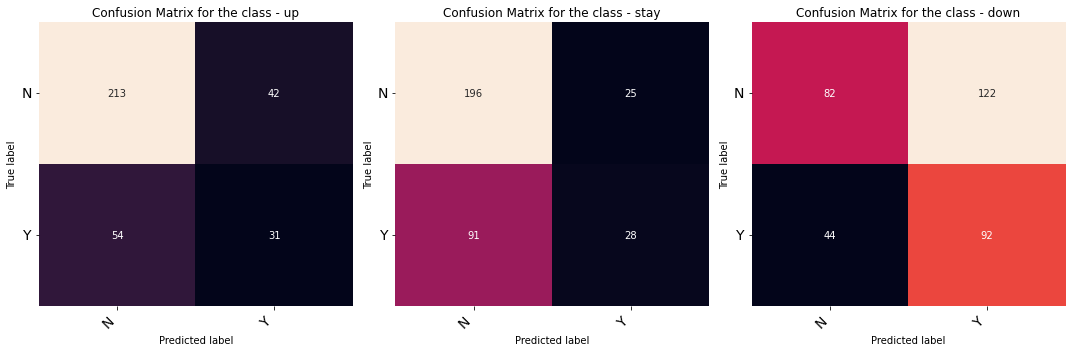

In [ ]:
multilabel_confusion_matrix(y_class_test, y_pred)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

labels = ["up", "stay", "down"]
    
for axes, cfs_matrix, label in zip(ax.flatten(), multilabel_confusion_matrix(y_class_test, y_pred), labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

### Add p_sentiment

In [ ]:
repeats = np.arange(50)
f1_list = []

for time in repeats:
    model = Sequential()
    model.add(Dense(2000, input_dim=X_p_train.shape[1], activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    adam = Adam(learning_rate=0.0005)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics="accuracy")
    model.fit(X_p_train, y_class_train, epochs=500, verbose=0, callbacks=[es_callback, lr_sched], class_weight=class_weight, shuffle=False)
    y_pred = model.predict(X_p_test)
    y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
    f1_list.append(f1_score(y_class_test, y_pred, average='weighted'))

    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    np.random.seed(888)
    random.seed(888)

print(np.array(f1_list).mean())
print(np.array(f1_list).std())

0.4295694720594659

### Add i_sentiment

In [ ]:
repeats = np.arange(50)
f1_list = []

for time in repeats:
    model = Sequential()
    model.add(Dense(2000, input_dim=X_p_train.shape[1], activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    adam = Adam(learning_rate=0.0005)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics="accuracy")
    model.fit(X_i_train, y_class_train, epochs=500, verbose=0, callbacks=[es_callback, lr_sched], class_weight=class_weight, shuffle=False)
    y_pred = model.predict(X_i_test)
    y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
    f1_list.append(f1_score(y_class_test, y_pred, average='weighted'))

    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    np.random.seed(888)
    random.seed(888)

np.array(f1_list).mean()
print(np.array(f1_list).std())

0.43459302928856125

### Add both indices

In [ ]:
repeats = np.arange(10)
f1_list = []

for time in repeats:
    model = Sequential()
    model.add(Dense(2000, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    adam = Adam(learning_rate=0.0005)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics="accuracy")
    model.fit(X_train, y_class_train, epochs=500, verbose=0, callbacks=[es_callback, lr_sched], class_weight=class_weight, shuffle=False)
    y_pred = model.predict(X_test)
    y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
    f1_list.append(f1_score(y_class_test, y_pred, average='weighted'))

    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    np.random.seed(888)
    random.seed(888)
print(np.array(f1_list).mean())
print(np.array(f1_list).std())

0.4728680758469432

In [ ]:
repeats = np.arange(1)
f1_list = []

for time in repeats:
    model = Sequential()
    model.add(Dense(2000, input_dim=(X_train.shape[1]), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    es_callback = EarlyStopping(monitor="accuracy", min_delta=0, patience=20)


    callback = LearningRateScheduler(scheduler)

    class_weight = {0: 2.5,
                1: 1,
                2: 2}
    adam = Adam(learning_rate=0.0005)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics="accuracy")
    model.fit(X_train, y_class_train, epochs=500, verbose=0, callbacks=[es_callback, lr_sched], class_weight=class_weight, shuffle=False)
    y_pred = model.predict(X_test)
    y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
    f1_list.append(f1_score(y_class_test, y_pred, average='weighted'))
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    np.random.seed(888)
    random.seed(888)
np.array(f1_list).mean()

0.4807666666666667

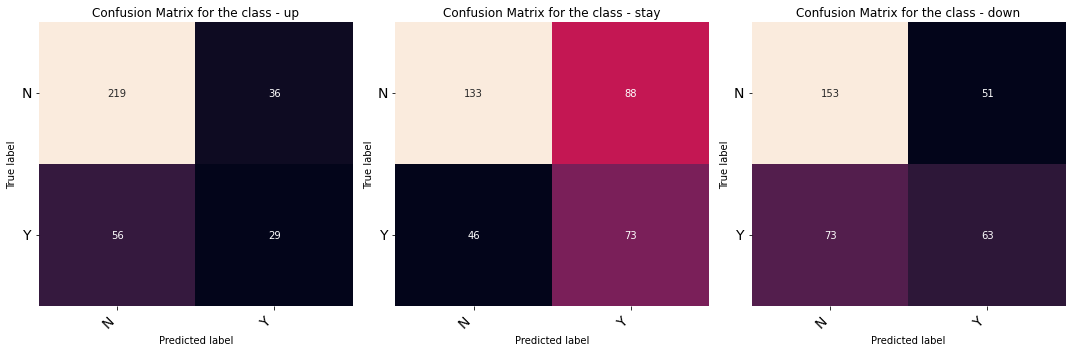

In [ ]:
multilabel_confusion_matrix(y_class_test, y_pred)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

labels = ["up", "stay", "down"]
    
for axes, cfs_matrix, label in zip(ax.flatten(), multilabel_confusion_matrix(y_class_test, y_pred), labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

## Regression

### Benchmark

In [ ]:
layersize = 1500
dropout = 0.05
lr = 5e-05
activationf = 'relu'

In [ ]:
repeats = np.arange(50)
mae_list_small = []

for time in repeats:

    model = Sequential()
    model.add(Dense(layersize, input_dim=X_small_train.shape[1], activation=activationf))
    model.add(Dropout(dropout))
    model.add(Dense(layersize, activation=activationf))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))

    adam = Adam(learning_rate=lr)
    model.compile(loss="mean_absolute_error", optimizer=adam, metrics="accuracy")
    model.fit(X_small_train, y_reg_train_scaled, epochs=500, verbose=0, callbacks=[es_callback, lr_sched], shuffle=False)
    y_pred = model.predict(X_small_test)
    y_pred = standard_scaler_y.inverse_transform(y_pred)    
    mae_list_small.append(mean_absolute_error(y_reg_test_scaled, y_pred))
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    np.random.seed(888)
    random.seed(888)
np.array(mae_list_small).mean()

0.5749096257541392

In [ ]:
np.array(mae_list_small).std()

0.02878901711469704

In [ ]:
repeats = np.arange(1)
mae_list_small = []

for time in repeats:

    model = Sequential()
    model.add(Dense(layersize, input_dim=X_small_train.shape[1], activation=activationf))
    model.add(Dropout(dropout))
    model.add(Dense(layersize, activation=activationf))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))

    adam = Adam(learning_rate=lr)
    model.compile(loss="mean_absolute_error", optimizer=adam, metrics="accuracy")
    model.fit(X_small_train, y_reg_train_scaled, epochs=500, verbose=0, callbacks=[es_callback, lr_sched], shuffle=False)
    y_pred = model.predict(X_small_test)
    y_pred = standard_scaler_y.inverse_transform(y_pred)    
    print(mean_absolute_error(y_reg_test_scaled, y_pred))

0.6041454129578997


In [ ]:
daily_error_no_sentiment = y_pred - y_reg_test

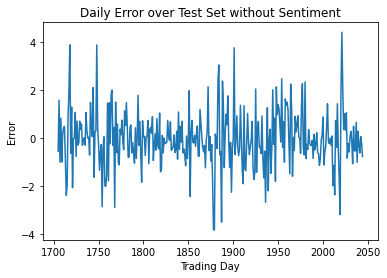

In [ ]:
daily_error_no_sentiment.plot.line(title='Daily Error over Test Set without Sentiment', ylabel='Error', xlabel='Trading Day', legend=None)

### Add  p_sentiment

In [ ]:
layersize = 1000 
dropo = 0.05
lr = 0.0005
activationf = 'tanh'

In [ ]:
repeats = np.arange(50)
mae_list = []

for time in repeats:

    model = Sequential()
    model.add(Dense(layersize, input_dim=X_p_train.shape[1], activation=activationf))
    model.add(Dropout(dropo))
    model.add(Dense(layersize, activation=activationf))
    model.add(Dropout(dropo))
    model.add(Dense(1, activation='linear'))

    adam = Adam(learning_rate=lr)
    model.compile(loss="mean_absolute_error", optimizer=adam, metrics="accuracy")
    model.fit(X_p_train, y_reg_train_scaled, epochs=500, verbose=0, callbacks=[es_callback, lr_sched], shuffle=False)
    y_pred = model.predict(X_p_test)
    y_pred = standard_scaler_y.inverse_transform(y_pred)    
    mae_list.append(mean_absolute_error(y_reg_test_scaled, y_pred))

    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    np.random.seed(888)
    random.seed(888)

np.array(mae_list).mean()

0.5525157268141997

In [ ]:
np.array(mae_list).std()

0.05920533021209409

### Add i_sentiment

In [ ]:
layersize = 750 
dropo = 0.2
lr = 5e-05
activationf = 'relu'

In [ ]:
repeats = np.arange(50)
mae_list = []

for time in repeats:

    model = Sequential()
    model.add(Dense(layersize, input_dim=X_i_train.shape[1], activation=activationf))
    model.add(Dropout(dropo))
    model.add(Dense(layersize, activation=activationf))
    model.add(Dropout(dropo))
    model.add(Dense(1, activation='linear'))

    adam = Adam(learning_rate=lr)
    model.compile(loss="mean_absolute_error", optimizer=adam, metrics="accuracy")
    model.fit(X_i_train, y_reg_train_scaled, epochs=500, verbose=0, callbacks=[es_callback, lr_sched], shuffle=False)
    y_pred = model.predict(X_i_test)
    y_pred = standard_scaler_y.inverse_transform(y_pred)
    mae_list.append(mean_absolute_error(y_reg_test_scaled, y_pred))

    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    np.random.seed(888)
    random.seed(888)

np.array(mae_list).mean()

0.5727942146103367

In [ ]:
np.array(mae_list).std()

0.03254067187803235

### Add both indices

In [ ]:
layersize = 1000 
dropout = 0.05
lr = 5e-05
activationf = 'tanh'

In [ ]:
repeats = np.arange(50)
mae_list_small = []

for time in repeats:

    model = Sequential()
    model.add(Dense(layersize, input_dim=X_train.shape[1], activation=activationf))
    model.add(Dropout(dropout))
    model.add(Dense(layersize, activation=activationf))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))

    adam = Adam(learning_rate=lr)
    model.compile(loss="mean_absolute_error", optimizer=adam, metrics="accuracy")
    model.fit(X_train, y_reg_train_scaled, epochs=500, verbose=0, callbacks=[es_callback, lr_sched], shuffle=False)
    y_pred = model.predict(X_test)
    y_pred = standard_scaler_y.inverse_transform(y_pred)    
    mae_list_small.append(mean_absolute_error(y_reg_test_scaled, y_pred))
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    np.random.seed(888)
    random.seed(888)
np.array(mae_list_small).mean()

0.521847530086482

In [ ]:
np.array(mae_list).std()

0.07019392582979231

## Create Graph

In [ ]:
model = Sequential()
model.add(Dense(layersize, input_dim=X_train.shape[1], activation=activationf))
model.add(Dropout(dropo))
model.add(Dense(layersize, activation=activationf))
model.add(Dropout(dropo))
model.add(Dense(1, activation='linear'))

adam = Adam(learning_rate=lr)
model.compile(loss="mean_absolute_error", optimizer=adam, metrics="accuracy")
model.fit(X_train, y_reg_train_scaled, epochs=500, verbose=0, callbacks=[es_callback, lr_sched], shuffle=False)
y_pred = model.predict(X_test)
y_pred = standard_scaler_y.inverse_transform(y_pred)    
mean_absolute_error(y_reg_test_scaled, y_pred)

0.5041635907475632

,daily_diff
1705,-0.540238
1706,1.582207
1707,-0.997681
1708,0.831889
1709,-0.989185
...,...
2040,-0.290416
2041,-0.613514
2042,0.070203
2043,-0.216638


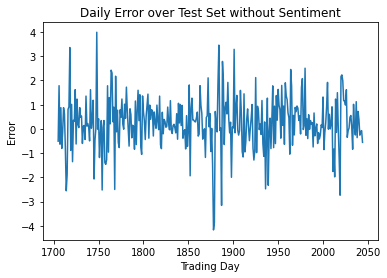

In [ ]:
(y_pred - y_reg_test).plot.line(title='Daily Error over Test Set without Sentiment', ylabel='Error', xlabel='Trading Day', legend=None)

daily_error_no_sentiment

In [ ]:
with_sentiment = y_pred - y_reg_test

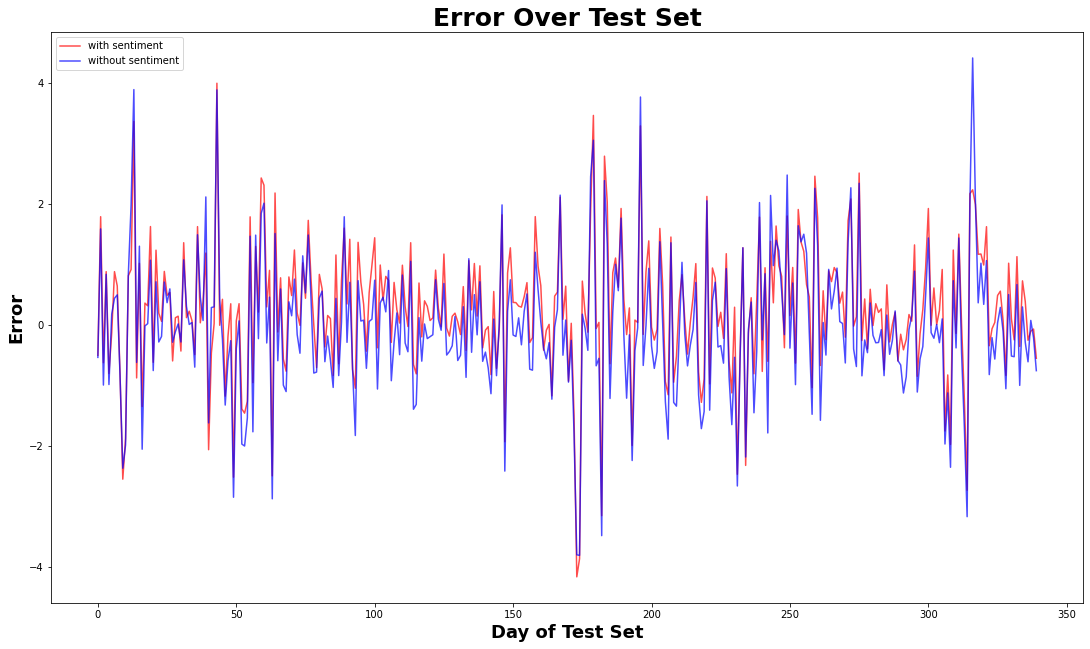

In [ ]:
plt.plot(np.array(with_sentiment), label="with sentiment", alpha=0.7, color='red')
plt.plot(np.array(daily_error_no_sentiment), label="without sentiment", alpha=0.7, color='blue')
plt.legend()
plt.title('Error Over Test Set', fontdict={'weight': 'bold', 'size': 25})
plt.xlabel('Day of Test Set', fontdict={'weight': 'bold', 'size': 18})
plt.ylabel('Error', fontdict={'weight': 'bold', 'size': 18})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)